## Checking out `2d`-seismic

In [3]:
import segyio
from segyio.tracefield import keys as trace_keys
from tqdm import tqdm_notebook
import numpy as np
import sys

In [4]:
path = '/notebooks/2d_seismic/VSY_SGY_uvz_43N/1903009_PURGEOinvPol-22_uvz.segy'

In [5]:
file = segyio.open(path, strict=False)
num_samples = file.header[0].get(trace_keys['TRACE_SAMPLE_COUNT'])
num_traces = len(file.header)

In [7]:
file.header[0]

{TRACE_SEQUENCE_LINE: 1, TRACE_SEQUENCE_FILE: 1, FieldRecord: 1, TraceNumber: 1, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 1, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 1, offset: 0, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 1, SourceGroupScalar: -100, SourceX: 76329682, SourceY: 701678573, GroupX: 0, GroupY: 0, CoordinateUnits: 1, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: -1000, LagTimeB: 0, DelayRecordingTime: -1000, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 2000, TRACE_SAMPLE_INTERVAL: 2000, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 1, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType: 1, SweepTraceTaperLengthStart: 0

* We can see that the header is different: `INLINE_3d` and `CROSSLINE_3D` keys are absent. So, `seismiqb` won't work with these files right of the bat. Let's check some more fields

In [8]:
num_samples

2000

In [9]:
num_traces

1463

In [10]:
file.header[1].get(trace_keys['CDP_X']) - file.header[0].get(trace_keys['CDP_X'])

2491

In [11]:
file.header[2].get(trace_keys['CDP_X']) - file.header[1].get(trace_keys['CDP_X'])

2490

In [12]:
file.header[3].get(trace_keys['CDP_X']) - file.header[2].get(trace_keys['CDP_X'])

2490

* Ok. We can clearly see that `CDP`s can be well aligned into lines. Let's check out one segy

In [20]:
len(file.trace)

1463

In [21]:
len(file.trace[0])

2000

In [22]:
lst = []

In [23]:
for i in range(len(file.trace)):
    lst.append(file.trace[i])

In [24]:
data_ = np.array(lst)

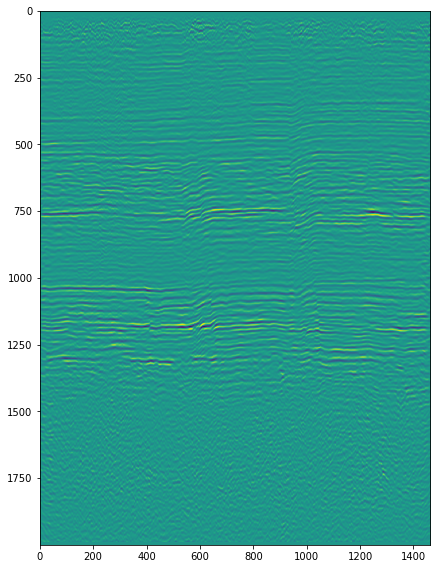

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 10))
ax.imshow(data_.T)

* Ok. Looks good!

Let's write a converter from `segy` to `hdf5`-format. Each `segy` takes one iline and a set of xlines.

# Writing converter

* to begin with, let's check out what is occupied by segys

In [33]:
def get_cdps_from_segys(segyfiles_paths):
    """ Get cdp-coordinates for a set of segy-files: cdp_pair, cdp_xs, cdp_ys.
    """
    # get min-max cdp-values
    cdp_pairs, cdp_xs, cdp_ys = [], [], []
    for path in segyfiles_paths:
        with segyio.open(path, strict=False) as segyfile:
            for header in segyfile.header:
                cdp_x, cdp_y = header.get(segyio.TraceField.CDP_X), header.get(segyio.TraceField.CDP_Y)
                cdp_xs.append(cdp_x)
                cdp_ys.append(cdp_y)
                cdp_pairs.append((cdp_x, cdp_y))

    return cdp_pairs, cdp_xs, cdp_ys

In [34]:
def scatter_on_area(cdp_pairs, cdp_xs=None, cdp_ys=None, x_range=None, y_range=None, scale=10000):
    # make scaled rectangle
    if x_range is None or y_range is None:
        x_min, x_max = min(cdp_xs), max(cdp_xs)
        y_min, y_max = min(cdp_ys), max(cdp_ys)
    else:
        x_min, x_max = x_range
        y_min, y_max = y_range
    area = np.zeros(shape=[int((x_max - x_min) / scale + 1), int((y_max - y_min) / scale + 1)])

    # put pairs in prepared area
    for value in cdp_pairs:
        scaled_value = int((value[0] - x_min) / scale), int((value[1] - y_min) / scale)
        if 0 <= scaled_value[0] <= (x_max - x_min) / scale + 1 and 0 <= scaled_value[1] <= (y_max - y_min) / scale + 1:
            area[scaled_value] = 1
    
    return area

In [35]:
from glob import glob

In [36]:
cdp_pairs, cdp_xs, cdp_ys = get_cdps_from_segys(glob('/notebooks/2d_seismic/VSY_SGY_uvz_43N/*.segy'))

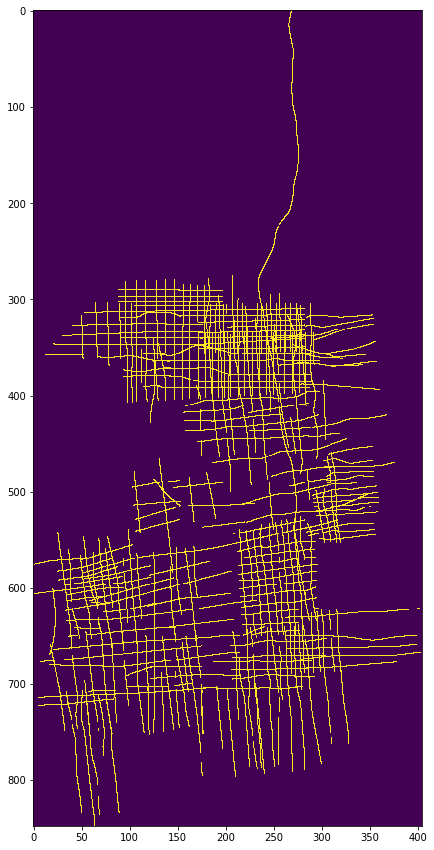

In [42]:
area_ = scatter_on_area(cdp_pairs, cdp_xs, cdp_ys, scale=30000)
fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(area_)

* what's interesting, some segys do not cover straight lines

In [43]:
x_range = min(cdp_xs), max(cdp_xs)
y_range = min(cdp_ys), max(cdp_ys)

In [44]:
x_range

(54862452, 80282379)

In [45]:
y_range

(700015304, 712128530)

* finally, let's write a converter to `hdf5`

In [310]:
import os
import h5py

def convert_2d_segy_to_h5py(path_segy, path_h5py=None, postfix='', ilines_offset=0, xlines_offset=0, dtype=np.float32):
    """ Convert 2d-segy to h5py-format applicable for seismiqb.
    """
    with segyio.open(path_segy, strict=False) as segyfile:
        # read segy-attributes
        first_header = segyfile.header[0]
        depth = len(segyfile.trace[0])
        delay = first_header.get(segyio.TraceField.DelayRecordingTime)
        sample_rate = first_header.get(segyio.TraceField.TRACE_SAMPLE_INTERVAL) / 1000
        
        # the number of "xlines"
        xlines_len = len(segyfile.trace)

        # make h5-dataset
        path_h5py = path_h5py or (os.path.splitext(path_segy)[0] + postfix + '.hdf5')
        if os.path.exists(path_h5py):
            os.remove(path_h5py)

        h5py_file = h5py.File(path_h5py, "a")
        cube_h5py = h5py_file.create_dataset('cube', (1, xlines_len, depth))
        cube_h5py_x = h5py_file.create_dataset('cube_x', (xlines_len, depth, 1))
        cube_h5py_h = h5py_file.create_dataset('cube_h', (depth, 1, xlines_len))

        # fill in traces from 2d-segy into h5py-cube
        with segyio.open(path_segy, 'r', strict=False) as segyfile:
            segyfile.mmap()

            description = 'Converting {} to h5py'.format('/'.join(path_segy.split('/')[-2:]))
            slide = np.zeros((xlines_len, depth))

            for i in range(xlines_len):
                trace = segyfile.trace[i]
                slide[i, :] = trace

            slide = slide.astype(dtype)
            cube_h5py[0, :, :] = slide

        # Save all the necessary attributes to the `info` group of the file
        attributes = ['depth', 'delay', 'sample_rate', 'value_min', 'value_max',
                      'ilines',
                      'xlines',
                      'zero_traces']
        for key, value in zip(attributes,
                              [depth, delay, sample_rate, np.min(slide), np.max(slide),
                               np.arange(ilines_offset, ilines_offset + 1),
                               np.arange(xlines_offset, xlines_offset + xlines_len),
                               ((np.max(slide, axis=1) - np.min(slide, axis=1)) == 0).astype(np.float32)]):
            h5py_file['/info/' + key] = value

        h5py_file.close()

In [ ]:
convert_2d_segy_to_h5py('/notebooks/2d_seismic/VSY_SGY_uvz_43N/1903009_PURGEOinvPol-22_uvz.segy',
                        path_h5py='/notebooks/2d_seismic_h5/file.hdf5')

## Working with Horizons-labelling

In [312]:
path_to_labels = '/notebooks/2d_seismic/HOR_3986_3286/A_anon.txt'

In [313]:
import pandas as pd

In [324]:
pd.read_csv(path_to_labels, delim_whitespace=True,
            names=['textname, number', 'cdp_x', 'cdp_y', 'height', 'othername']).head(5)[['cdp_x', 'cdp_y']]

cdp_x         cdp_y
Line_FXNAT3286026_LMK  752569.26955  7.137957e+06
Line_FXNAT3286026_LMK  752565.78346  7.137987e+06
Line_FXNAT3286026_LMK  752562.29738  7.138017e+06
Line_FXNAT3286026_LMK  752558.81130  7.138046e+06
Line_FXNAT3286026_LMK  752555.32522  7.138076e+06

* func for gathering `cdps` from labels

In [45]:
import pandas as pd
def get_cdps_from_labels(paths):
    """ Get cdp-coordinates for a set of segy-files: cdp_pair, cdp_xs, cdp_ys.
    """
    # get min-max cdp-values
    cdp_pairs, cdp_xs, cdp_ys = [], [], []
    for path in paths:

        coords = pd.read_csv(path, delim_whitespace=True,
                             names=['textname, number', 'cdp_x', 'cdp_y', 'height',
                             'othername'])[['cdp_x', 'cdp_y']].values
        cdp_pairs.extend(list(coords))
        cdp_xs.extend(list(coords[:, 0]))
        cdp_ys.extend(list(coords[:, 1]))

    return cdp_pairs, cdp_xs, cdp_ys

In [56]:
ps, xs, ys = get_cdps_from_labels(['/notebooks/2d_seismic/HOR_3986_3286/A_anon.txt'])

In [67]:
x_range

(54862452, 80282379)

In [68]:
y_range

(700015304, 712128530)